<a href="https://colab.research.google.com/github/anthonyramos-star/Processamento-de-imagens-de-computa-o-gr-fica---E02/blob/main/Projeto_Unidade_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
import json


In [ ]:
def cor_predominante(imagem):
    """Detecta cor predominante (média RGB)"""
    media = imagem.mean(axis=(0,1))
    return tuple(int(v) for v in media)

def carregar_imagem(caminho):
    if not os.path.exists(caminho):
        print("Erro: Caminho inválido.")
        return None
    img = cv2.imread(caminho)
    if img is None:
        print("Erro ao carregar imagem.")
        return None
    print(f"Imagem carregada com sucesso: {caminho}")
    print(f"Dimensões: {img.shape[1]}x{img.shape[0]} px")
    print("Cor predominante (RGB):", cor_predominante(img))
    return img


def converter_cinza(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def converter_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


def equalizar_histograma(img):
    gray = converter_cinza(img)
    return cv2.equalizeHist(gray)


def binarizar_imagem(img, limiar=127):
    gray = converter_cinza(img)
    _, binaria = cv2.threshold(gray, limiar, 255, cv2.THRESH_BINARY)
    return binaria


def detectar_bordas(img):
    gray = converter_cinza(img)
    return cv2.Canny(gray, 100, 200)


def propriedades_basicas(img):
    gray = converter_cinza(img)
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    return {"qtd_objetos": len(contours), "area_media": np.mean(areas) if areas else 0}


def calcular_metricas_textura(img):
    gray = converter_cinza(img)
    entropia = shannon_entropy(gray)
    variacao = np.var(gray)
    glcm = graycomatrix(gray, [1], [0], 256, symmetric=True, normed=True)
    homogeneidade = graycoprops(glcm, 'homogeneity')[0, 0]
    return {"entropia": entropia, "variacao": variacao, "homogeneidade": homogeneidade}


def classificar_complexidade(metricas):
    if metricas["entropia"] > 5 or metricas["variacao"] > 5000:
        return "Alta complexidade"
    return "Baixa complexidade"


def mapa_textura(img):
    gray = converter_cinza(img)
    laplaciano = cv2.Laplacian(gray, cv2.CV_64F)
    densidade = np.abs(laplaciano)
    plt.imshow(densidade, cmap='hot')
    plt.title("Mapa de Padrões (Textura Densa)")
    plt.show()


def comparar_metricas(imgs):
    nomes, entropias, homogeneidades = [], [], []
    for nome, img in imgs.items():
        m = calcular_metricas_textura(img)
        nomes.append(nome)
        entropias.append(m["entropia"])
        homogeneidades.append(m["homogeneidade"])
    plt.plot(nomes, entropias, label="Entropia")
    plt.plot(nomes, homogeneidades, label="Homogeneidade")
    plt.legend()
    plt.title("Comparação: Entropia x Homogeneidade")
    plt.show()


def gerar_relatorio(img, metricas, complexidade, caminho_relatorio="relatorio.txt"):
    with open(caminho_relatorio, "w") as f:
        f.write("=== RELATÓRIO DE ANÁLISE DE IMAGEM ===\n")
        f.write(f"Dimensões: {img.shape[1]}x{img.shape[0]}\n")
        f.write(f"Entropia: {metricas['entropia']:.3f}\n")
        f.write(f"Variação: {metricas['variacao']:.3f}\n")
        f.write(f"Homogeneidade: {metricas['homogeneidade']:.3f}\n")
        f.write(f"Complexidade: {complexidade}\n")
    print(f"Relatório salvo como '{caminho_relatorio}'.")



def detectar_formas_geometricas(img, json_path="/content/forms.json"):
    """
    Detecta formas geométricas com base no número de lados detectado a partir das bordas.
    - Usa contornos sobre as bordas Canny.
    - Associa o número de lados ao nome da forma conforme o arquivo JSON fornecido.
    """

    with open(json_path, "r", encoding="utf-8") as f:
        formas_dict = json.load(f)


    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bordas = cv2.Canny(gray, 80, 200)


    contornos, _ = cv2.findContours(bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_saida = img.copy()
    formas_detectadas = []

    for contorno in contornos:
        if cv2.contourArea(contorno) < 200:
            continue


        perimetro = cv2.arcLength(contorno, True)
        aprox = cv2.approxPolyDP(contorno, 0.04 * perimetro, True)
        lados = len(aprox)

        nome_forma = formas_dict.get(str(lados), f"{lados} lados")

        M = cv2.moments(contorno)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv2.putText(img_saida, nome_forma, (cx - 50, cy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)


        cv2.drawContours(img_saida, [aprox], -1, (0, 255, 0), 2)
        formas_detectadas.append({"forma": nome_forma, "lados": lados})


    plt.imshow(cv2.cvtColor(img_saida, cv2.COLOR_BGR2RGB))
    plt.title("Formas Geométricas Detectadas")
    plt.axis('off')
    plt.show()

    if not formas_detectadas:
        print("Nenhuma forma geométrica significativa foi detectada.")
    else:
        print("\nFormas detectadas:")
        for f in formas_detectadas:
            print(f" - {f['forma']} ({f['lados']} lados)")

    return formas_detectadas



=== SISTEMA DE ANÁLISE DE PADRÕES EM IMAGENS ===
Digite o caminho da imagem (ex: /content/imagem.jpg): /content/teste1.jpg
Imagem carregada com sucesso: /content/teste1.jpg
Dimensões: 1742x980 px
Cor predominante (RGB): (192, 189, 202)

--- MENU ---
1. Converter para escala de cinza
2. Converter para HSV
3. Equalizar histograma
4. Binarizar imagem
5. Detectar bordas
6. Calcular métricas de textura
7. Exibir mapa de textura
8. Gerar relatório manual
9. Detectar formas geométricas
0. Sair
Escolha uma opção: 1


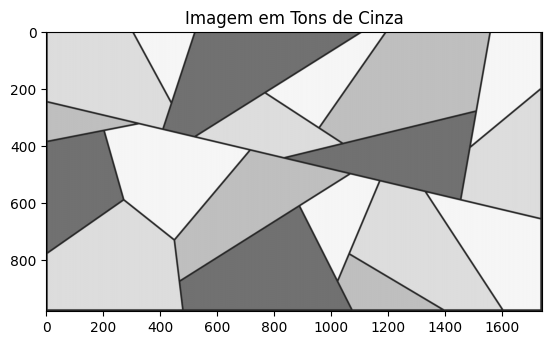


--- MENU ---
1. Converter para escala de cinza
2. Converter para HSV
3. Equalizar histograma
4. Binarizar imagem
5. Detectar bordas
6. Calcular métricas de textura
7. Exibir mapa de textura
8. Gerar relatório manual
9. Detectar formas geométricas
0. Sair
Escolha uma opção: 2


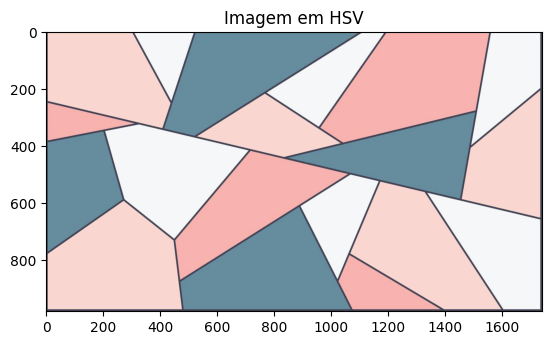


--- MENU ---
1. Converter para escala de cinza
2. Converter para HSV
3. Equalizar histograma
4. Binarizar imagem
5. Detectar bordas
6. Calcular métricas de textura
7. Exibir mapa de textura
8. Gerar relatório manual
9. Detectar formas geométricas
0. Sair
Escolha uma opção: 3


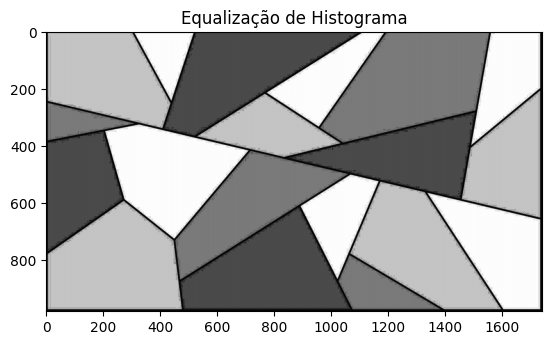


--- MENU ---
1. Converter para escala de cinza
2. Converter para HSV
3. Equalizar histograma
4. Binarizar imagem
5. Detectar bordas
6. Calcular métricas de textura
7. Exibir mapa de textura
8. Gerar relatório manual
9. Detectar formas geométricas
0. Sair
Escolha uma opção: 4


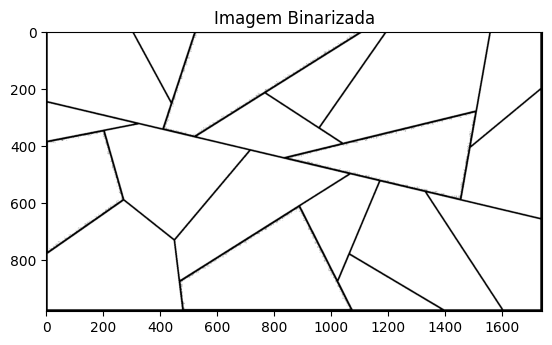


--- MENU ---
1. Converter para escala de cinza
2. Converter para HSV
3. Equalizar histograma
4. Binarizar imagem
5. Detectar bordas
6. Calcular métricas de textura
7. Exibir mapa de textura
8. Gerar relatório manual
9. Detectar formas geométricas
0. Sair
Escolha uma opção: 5


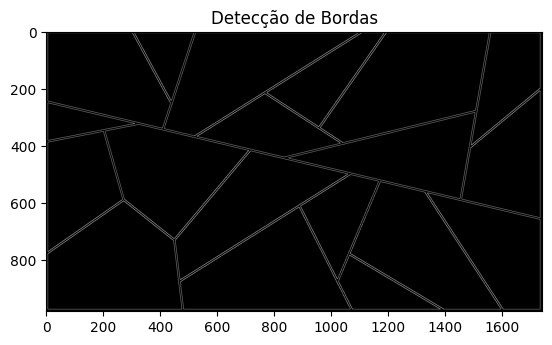


--- MENU ---
1. Converter para escala de cinza
2. Converter para HSV
3. Equalizar histograma
4. Binarizar imagem
5. Detectar bordas
6. Calcular métricas de textura
7. Exibir mapa de textura
8. Gerar relatório manual
9. Detectar formas geométricas
0. Sair
Escolha uma opção: 6

Métricas: {'entropia': np.float64(3.116851235742878), 'variacao': np.float64(2687.975977741909), 'homogeneidade': np.float64(0.9080309412117817)}
Complexidade: Baixa complexidade

--- MENU ---
1. Converter para escala de cinza
2. Converter para HSV
3. Equalizar histograma
4. Binarizar imagem
5. Detectar bordas
6. Calcular métricas de textura
7. Exibir mapa de textura
8. Gerar relatório manual
9. Detectar formas geométricas
0. Sair
Escolha uma opção: 7


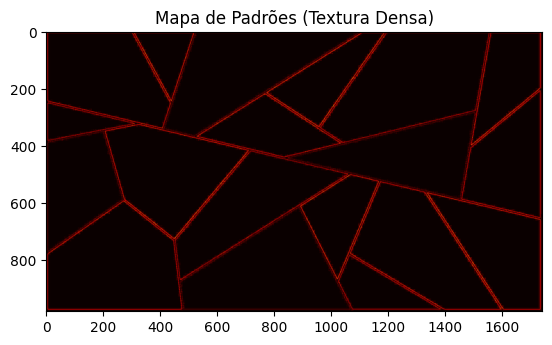


--- MENU ---
1. Converter para escala de cinza
2. Converter para HSV
3. Equalizar histograma
4. Binarizar imagem
5. Detectar bordas
6. Calcular métricas de textura
7. Exibir mapa de textura
8. Gerar relatório manual
9. Detectar formas geométricas
0. Sair
Escolha uma opção: 9
Detectando formas geométricas...


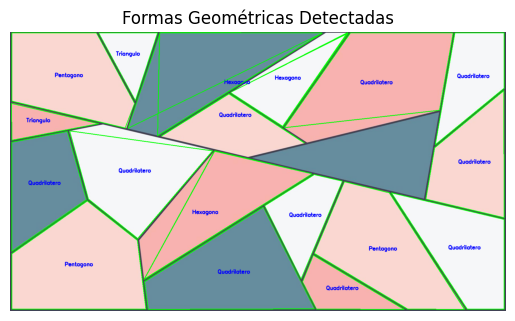


Formas detectadas:
 - Quadrilatero (4 lados)
 - Quadrilatero (4 lados)
 - Pentagono (5 lados)
 - Quadrilatero (4 lados)
 - Pentagono (5 lados)
 - Quadrilatero (4 lados)
 - Hexagono (6 lados)
 - Quadrilatero (4 lados)
 - Quadrilatero (4 lados)
 - Triangulo (3 lados)
 - Quadrilatero (4 lados)
 - Quadrilatero (4 lados)
 - Quadrilatero (4 lados)
 - Triangulo (3 lados)
 - Quadrilatero (4 lados)
 - Hexagono (6 lados)
 - Hexagono (6 lados)
 - Pentagono (5 lados)

--- MENU ---
1. Converter para escala de cinza
2. Converter para HSV
3. Equalizar histograma
4. Binarizar imagem
5. Detectar bordas
6. Calcular métricas de textura
7. Exibir mapa de textura
8. Gerar relatório manual
9. Detectar formas geométricas
0. Sair
Escolha uma opção: 8
Relatório salvo como 'relatorio.txt'.

--- MENU ---
1. Converter para escala de cinza
2. Converter para HSV
3. Equalizar histograma
4. Binarizar imagem
5. Detectar bordas
6. Calcular métricas de textura
7. Exibir mapa de textura
8. Gerar relatório manual
9. Dete

In [ ]:
def main():
    print("=== SISTEMA DE ANÁLISE DE PADRÕES EM IMAGENS ===")
    caminho = input("Digite o caminho da imagem (ex: /content/imagem.jpg): ")
    img = carregar_imagem(caminho)
    if img is None:
        return

    while True:
        print("\n--- MENU ---")
        print("1. Converter para escala de cinza")
        print("2. Converter para HSV")
        print("3. Equalizar histograma")
        print("4. Binarizar imagem")
        print("5. Detectar bordas")
        print("6. Calcular métricas de textura")
        print("7. Exibir mapa de textura")
        print("8. Gerar relatório manual")
        print("9. Detectar formas geométricas")
        print("0. Sair")

        time.sleep(1)
        opcao = input("Escolha uma opção: ")

        if opcao == "1":
            plt.imshow(converter_cinza(img), cmap='gray')
            plt.title("Imagem em Tons de Cinza")
            plt.show()

        elif opcao == "2":
            hsv = converter_hsv(img)
            plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
            plt.title("Imagem em HSV")
            plt.show()

        elif opcao == "3":
            eq = equalizar_histograma(img)
            plt.imshow(eq, cmap='gray')
            plt.title("Equalização de Histograma")
            plt.show()

        elif opcao == "4":
            binaria = binarizar_imagem(img)
            plt.imshow(binaria, cmap='gray')
            plt.title("Imagem Binarizada")
            plt.show()

        elif opcao == "5":
            bordas = detectar_bordas(img)
            plt.imshow(bordas, cmap='gray')
            plt.title("Detecção de Bordas")
            plt.show()

        elif opcao == "6":
            metricas = calcular_metricas_textura(img)
            complexidade = classificar_complexidade(metricas)
            print(f"\nMétricas: {metricas}")
            print(f"Complexidade: {complexidade}")

        elif opcao == "7":
            mapa_textura(img)

        elif opcao == "8":
            metricas = calcular_metricas_textura(img)
            complexidade = classificar_complexidade(metricas)
            gerar_relatorio(img, metricas, complexidade)

        elif opcao == "9":
            print("Detectando formas geométricas...")
            detectar_formas_geometricas(img, json_path="/content/forms.json")


        elif opcao == "0":
            print("Encerrando o programa...")
            break

        else:
            print("Opção inválida. Tente novamente.")


if __name__ == "__main__":
    main()